## Change Detection with Hypothesis Testing

The following script will conduct a basic implementation of change dection using diferencing techniques combined with hypothesis testing to demonstrate the detection of deforestation.  The user should go to the  'User Inputs' section and enter the relevant information.  The output of the script is a 3-band geotiff with the following bands: Red = Difference in mean photosynthetic vegetation between a baseline period and recent period; Green = Difference in standard deviation OR the -log(p-value) of the Levene statistic; Blue = -log(p-value) of the Welch T-test


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from affine import Affine

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, DEADataHandling
from SignificanceTests import significance_tests

### User Inputs

In [22]:
#Enter coordinates for the analysis and the name of the AOI
AOI= 'Kowen_Forest'
lat, lon = -35.301274, 149.306497
latLon_adjust = 0.05

#length of time from start of baseline to end of change period
time_period = ('2002-01-01', '2018-12-31')

#Year at which baseline period ends and 'change' period starts
endofBaseline = 2012

#do you want to inlude a variance hypothesis test?
varianceTest = False

### Retrieve data (Fractional Cover)

In [4]:
dc = datacube.Datacube(app='change_detect')
# Set up query
query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
         'lat': (lat - latLon_adjust, lat + latLon_adjust),
         'time': time_period}

fc = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'], product='fc',
        masked_prop=0.25, mask_pixel_quality=True)

Loading ls5 pixel quality
    Loading 93 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 19 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 79 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### create baseline period and change period 
- only interested in PV

In [6]:
baseline = fc.PV.sel(time=fc['time.year']<=endofBaseline)
recent = fc.PV.sel(time=fc['time.year']>=(endofBaseline+1))

### conduct hypothesis tests on mean

 - can include a variance hypothesis test if you like

In [23]:
#welch t-test (fast)
tstat, p_tstat = significance_tests(xarray_a = baseline, xarray_b = recent, levene_test=False, t_test=True)

if varianceTest:
    #Levene test (will take a while)
    levene, p_levene = significance_tests(xarray_a = baseline, xarray_b = recent, levene_test=True, t_test=False)

starting T-test
finished T-test


### Transform P values and calculate the mean difference between periods

In [24]:
#negative log of p-values so numbers are larger
negLog_p_tstat = -np.log(p_tstat)
mean_diff = baseline.mean('time') - recent.mean('time')
std_diff = baseline.std('time') - recent.std('time')

if varianceTest: 
    negLog_p_levene = -np.log(p_levene)

### Create RGB geotiff and export

In [25]:
#create rgb xarray object and export geotiff
x = {'mean_diff': mean_diff, 'std_diff': std_diff, 'p_tstat': negLog_p_tstat}
rgb_changeDetect = xr.Dataset(x, attrs={'crs' : CRS('EPSG:3577'),'affine': fc.affine })
DEADataHandling.dataset_to_geotiff("results/" + AOI + "_rgb_changeDetect.tif", rgb_changeDetect)

if varianceTest:
    x = {'mean_diff': mean_diff, 'p_levene': negLog_p_levene, 'p_tstat': negLog_p_tstat}
    rgb_changeDetect = xr.Dataset(x, attrs={'crs' : CRS('EPSG:3577'),'affine': fc.affine })

    DEADataHandling.dataset_to_geotiff("results/" + AOI + "_rgb_leveneChangeDetect.tif", rgb_changeDetect)

This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. Please revise your notebooks to use this function instead


### Plot results

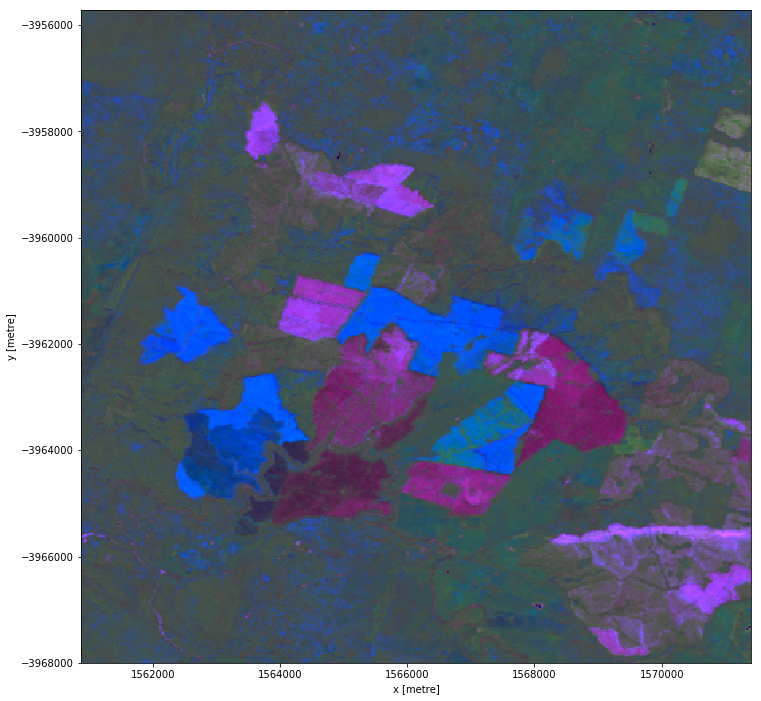

In [30]:
DEAPlotting.rgb(rgb_changeDetect, bands=['mean_diff', 'std_diff', 'p_tstat'], size=12, percentile_stretch = (0.01, 0.99))

if varianceTest:
    DEAPlotting.rgb(rgb_changeDetect, bands=['mean_diff', 'p_levene', 'p_tstat'], size=12, percentile_stretch = (0.01, 0.99))